In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.attention.luong'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [2893, 3701, 1] 蔬菜/种植/<EOS> 0.00955108843539 -4.6511 -4.6511 [-2.2767551, -1.382759, -0.99158615]


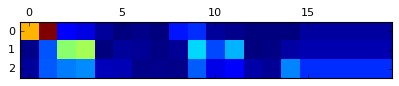

beam search using time(ms): 775.095939636
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0961318284256 -2.34203 -2.34203 [-0.65660346, -0.0065856799, -1.6788456]


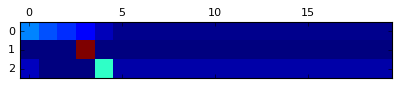

beam search using time(ms): 250.79202652
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0665804592837 -2.70934 -2.70934 [-0.86926389, -0.0090494724, -1.8310307]


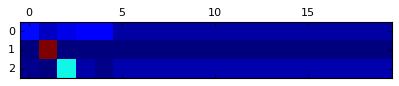

beam search using time(ms): 245.465040207
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.190454309658 -1.65834 -1.65834 [-0.28877547, -0.14913601, -0.043803729, -1.1766278]


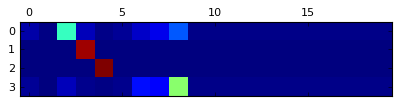

beam search using time(ms): 249.877929688
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [19, 807, 752, 1] 高/晓/松/<EOS> 0.040696567819 -3.20161 -3.20161 [-1.9274503, -0.42321327, -0.11868174, -0.73226619]


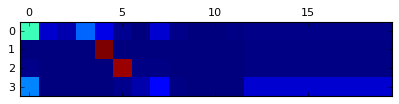

beam search using time(ms): 249.169111252
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 503, 57, 1] 王/凯/整容/前/照片/<EOS> 0.0573600198962 -2.85841 -2.85841 [-0.60604089, -0.0098575465, -0.19275098, -1.0899814, -0.87254208, -0.087234631]


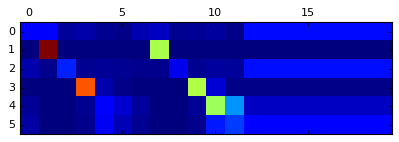

beam search using time(ms): 253.811120987
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [163, 62, 107, 1] 性感/黑/丝/<EOS> 0.01322253951 -4.32583 -4.32583 [-1.1990756, -1.3381261, -0.011833235, -1.7767975]


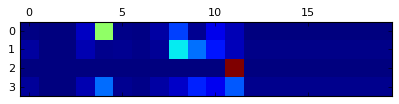

beam search using time(ms): 255.961894989
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0209531735039 -3.86547 -3.86547 [-2.1592665, -0.18988812, -1.5163107]


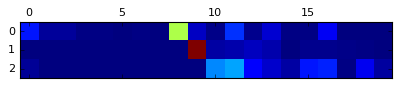

beam search using time(ms): 241.039991379
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.0142862885036 -4.24846 -4.24846 [-0.48869646, -3.0127354, -0.74702322]


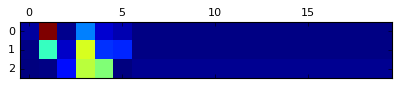

beam search using time(ms): 238.716840744
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.0818631922309 -2.50271 -2.50271 [-0.81431419, -0.01517055, -0.55678821, -0.15636845, -0.96006435]


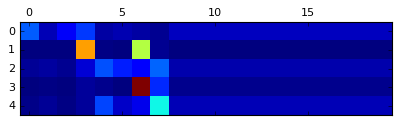

beam search using time(ms): 241.93406105
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [3885, 146, 30, 1] 6s/手机/壁纸/<EOS> 0.0127215473163 -4.36446 -4.36446 [-1.5603049, -1.0904218, -0.56205404, -1.151677]


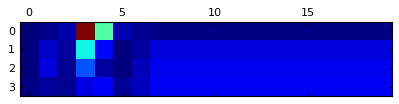

beam search using time(ms): 284.776926041


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 775, 448, 1] 赵丽/颖/古装/剧照/<EOS> 0.0904333023443 -2.40314 -2.40314 [-0.28884354, -0.000915704, -0.44250202, -1.3284127, -0.34246883]


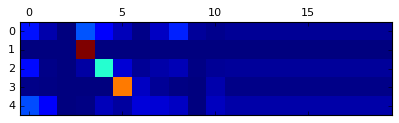

beam search using time(ms): 268.191099167


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [323, 56, 45, 301, 758, 1] 幼儿/园/简/笔画/动物/<EOS> 0.0105727515819 -4.54948 -4.54948 [-1.0154142, -0.21651784, -1.2958698, -0.027217913, -1.2525971, -0.74185807]


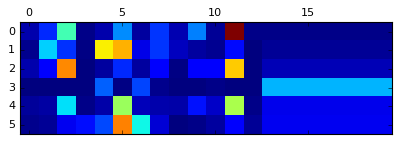

beam search using time(ms): 251.548051834


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 11, 5593, 1] 美甲/美/睫/<EOS> 0.0314295435104 -3.46001 -3.46001 [-0.39742136, -1.4043516, -0.41861683, -1.2396171]


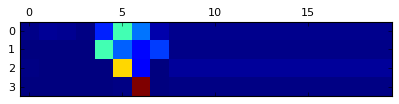

beam search using time(ms): 246.725797653


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.0398101628651 -3.22363 -3.22363 [-1.828045, -0.018203458, -1.3773845]


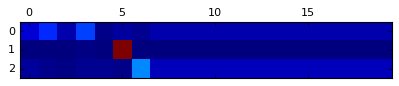

beam search using time(ms): 246.160030365


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 18755, 1] 房价/上涨/<EOS> 0.0117920180514 -4.44033 -4.44033 [-2.2276978, -1.6943687, -0.5182656]


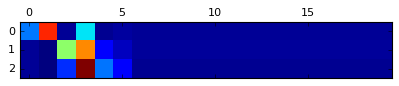

beam search using time(ms): 240.419864655


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [10515, 4961, 1] 职称/制度/<EOS> 0.00240857292129 -6.02872 -6.02872 [-3.676471, -1.8607086, -0.49154115]


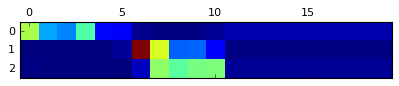

beam search using time(ms): 272.289991379


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [4470, 208, 1] 骷髅/纹身/<EOS> 0.0276562642155 -3.5879 -3.5879 [-1.9083784, -0.81976736, -0.85975748]


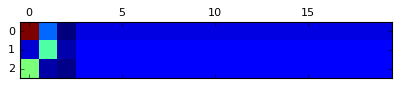

beam search using time(ms): 255.656957626


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0689415542033 -2.6745 -2.6745 [-0.60090017, -0.0024729169, -0.0023142719, -2.0688088]


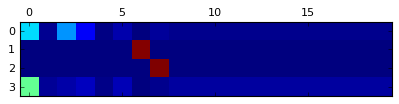

酷似/朴/姬/兰/的/刘/亦/菲
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0210156468335 -3.86249 -3.86249 [-0.60090017, -0.0024729169, -0.0023142719, -2.7309277, -0.52587301]


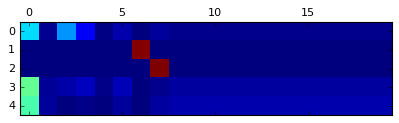

beam search using time(ms): 353.16491127


In [16]:
inference('酷似朴姬兰的刘亦菲', 2)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0475892505205 -3.04515 -3.04515 [-1.0501533, -0.0061904117, -0.0041780095, -1.9846267]


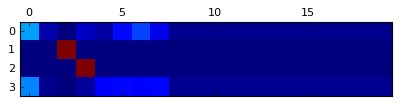

酷似/刘/亦/菲/的/朴/姬/兰
1 [20, 1] <UNK>/<EOS> 0.0201227493985 -3.9059 -3.9059 [-3.3266225, -0.57928169]


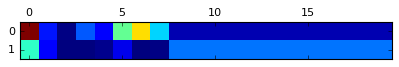

酷似/刘/亦/菲/的/朴/姬/兰
2 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0155482542229 -4.16381 -4.16381 [-1.0501533, -0.0061904117, -0.0041780095, -2.7304249, -0.37286031]


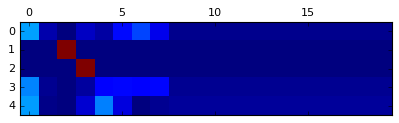

酷似/刘/亦/菲/的/朴/姬/兰
3 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0109538810584 -4.51406 -4.51406 [-2.8421912, -0.047058381, -0.91343224, -0.71137941]


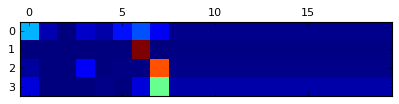

酷似/刘/亦/菲/的/朴/姬/兰
4 [869, 1474, 1] 朴/姬/<EOS> 0.00849181164262 -4.76865 -4.76865 [-2.8421912, -0.047058381, -1.8794032]


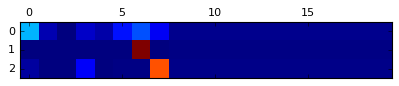

beam search using time(ms): 579.82301712


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0391312181272 -3.24083 -3.24083 [-1.5456078, -0.0061348462, -1.6890922]


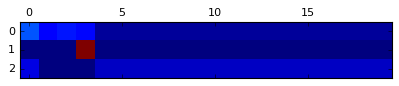

beam search using time(ms): 260.645866394


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.0380596375339 -3.2686 -3.2686 [-1.3900781, -0.0058805551, -1.8726423]


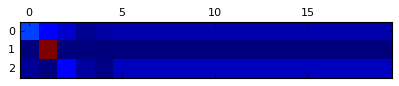

beam search using time(ms): 249.891996384


In [19]:
inference('打篮球好不好')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [20, 1] <UNK>/<EOS> 0.0155836963367 -4.16153 -4.16153 [-3.674087, -0.48744279]


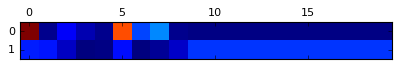

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [157, 10898, 1] 南/美洲/<EOS> 0.0125418821956 -4.37868 -4.37868 [-2.4753003, -0.050797064, -1.8525844]


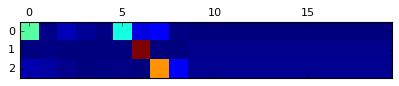

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [157, 10898, 6, 1] 南/美洲/图片/<EOS> 0.00189774328448 -6.26709 -6.26709 [-2.4753003, -0.050797064, -3.542109, -0.19888341]


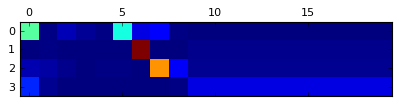

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
3 [9525, 1] 夏威夷/<EOS> 0.00173148541811 -6.35878 -6.35878 [-4.0814919, -2.2772837]


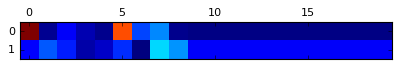

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
4 [157, 10898, 10258, 1] 南/美洲/群岛/<EOS> 0.00124954342474 -6.68498 -6.68498 [-2.4753003, -0.050797064, -2.7171445, -1.4417353]


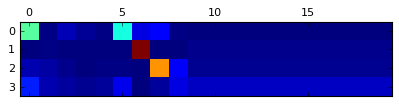

beam search using time(ms): 598.238945007


In [20]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 5)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0209531834952 -3.86546 -3.86546 [-2.1592667, -0.18988782, -1.5163102]


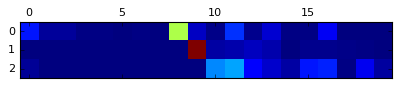

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 16400, 670, 1] 彭/于/晏/寒战/2/<EOS> 0.0121801693876 -4.40795 -4.40795 [-1.9980433, -0.0035636034, -0.064464472, -0.81229132, -0.7143991, -0.81518406]


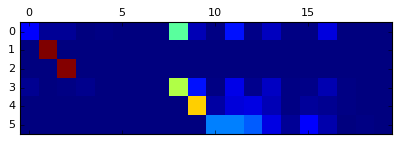

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [20, 1] <UNK>/<EOS> 0.00758386748615 -4.88173 -4.88173 [-4.2523422, -0.62939]


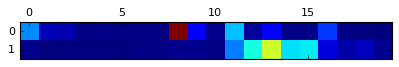

beam search using time(ms): 406.430006027


In [21]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)